In [ ]:
# change directory to sssl folder
%cd ..

/gpfs01/berens/user/jdoehl/GitHub/sssl


In [6]:
import pandas as pd
import torch


paths = dict(
    sim_clr = 'batch_metrics/embed_histories.pkl',
    no_decay = 'batch_metrics/embed_histories_no_decay.pkl',
    no_decay_no_momentum = 'batch_metrics/embed_histories_no_decay_no_momentum.pkl',
    # no_decay_no_momentum2 = "batch_metrics/embed_histories_no_decay_no_momentum-andrews_loss.pkl",
    # no_decay_no_momentum_atr0_5 = "batch_metrics/embed_histories_attraction_factor=0.5.pkl",
    # sim_clr_atr0_1 = "batch_metrics/embed_histories_attraction_factor=0.1.pkl",
    # attr_0_8_rep_1 = "batch_metrics/embed_histories_attr=0.8_rep=1.pkl",
    # attr_1_rep_0_8 = "batch_metrics/embed_histories_attr=1_rep=0.8.pkl"
    # grad_update_alignment = "batch_metrics/embed_histories_grad_update_alignment.pkl",
    # grad_update_alignment_no_decay = "batch_metrics/embed_histories_grad_update_alignment_no_decay.pkl",
    # grad_update_alignment_no_decay_no_momentum = "batch_metrics/embed_histories_grad_update_alignment_no_decay_no_momentum.pkl",
    sim_clr_grad_alignment = "batch_metrics/sim_clr_histories.pkl",
    sim_clr_histories_no_decay_no_momentum = "batch_metrics/sim_clr_histories_no_decay_no_momentum.pkl",
)

df_dict = {}
for name, path in paths.items():
    df_dict[name] = pd.read_pickle(path)

df = df_dict["no_decay"]

def stack_with_len(df, length):
    """uses torch.stack on all tensors contained in df.value with tensor.shape[-1] == length"""
    lst = []
    for tensor in df.value:
        if tensor.shape[-1] == length:
            lst.append(tensor)
    return torch.stack(lst)

In [19]:
set(df.type)

{'batch_used_indicies',
 'cos_sim_to_og_view_after_step',
 'cos_sim_to_og_view_before_step',
 'embed_norm',
 'embed_update_cos_sim',
 'kNN_accuracy_cosine',
 'og_view_grad1_cos_sim',
 'og_view_grad2_cos_sim',
 'view1_grad1_cos_sim',
 'view1and2_norm_after_optim_step',
 'view1and2_norm_before_optim_step',
 'view2_grad2_cos_sim',
 'views_cos_sim_after_step',
 'views_cos_sim_before_step'}

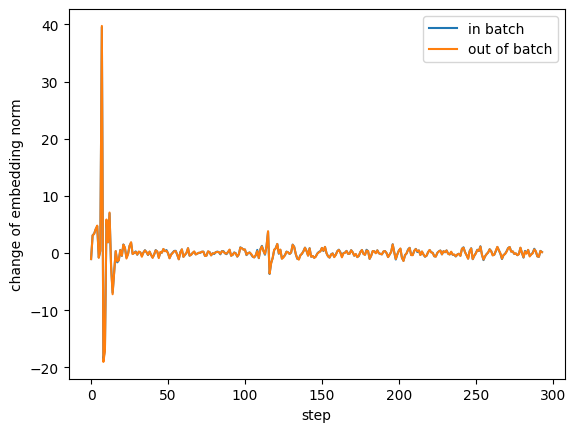

In [20]:
import torch
from matplotlib import pyplot as plt
import numpy as np

cos_sims = df[df.type == "embed_norm"]

change_embed_norm_in_batch = []
change_embed_norm_out_batch = []

for i, embed_norm_tuple in enumerate(cos_sims[1:].itertuples()):
    previous_embed_norm = cos_sims.iloc[i].value
    embed_norm = embed_norm_tuple.value
    epoch = embed_norm_tuple.epoch
    batch = embed_norm_tuple.batch
    indices = df[df.type == "batch_used_indicies"]
    indices = indices[indices.epoch == epoch]
    indices = indices[indices.batch == batch].value.item()

    previous_embed_norm_in_batch = previous_embed_norm[indices]
    embed_norm_in_batch = embed_norm[indices]
    change_embed_norm_in_batch.append((embed_norm_in_batch - previous_embed_norm_in_batch).mean())
    

    mask = torch.ones(embed_norm.shape[0], dtype=torch.bool)
    mask[indices] = False  # mark the ones you want to exclude
    previous_embed_norm_out_batch = previous_embed_norm[mask]
    embed_norm_out_batch = embed_norm[mask]
    change_embed_norm_out_batch.append((embed_norm_out_batch - previous_embed_norm_out_batch).mean())

change_embed_norm_in_batch = torch.tensor(np.stack(change_embed_norm_in_batch))
change_embed_norm_out_batch = torch.tensor(np.stack(change_embed_norm_out_batch))

up_to_step = 1000
plt.plot(change_embed_norm_in_batch[:up_to_step], label="in batch", alpha=1)
plt.plot(change_embed_norm_out_batch[:up_to_step], label="out of batch", alpha=1)
plt.legend()
plt.ylabel("change of embedding norm")
plt.xlabel("step")
plt.show()

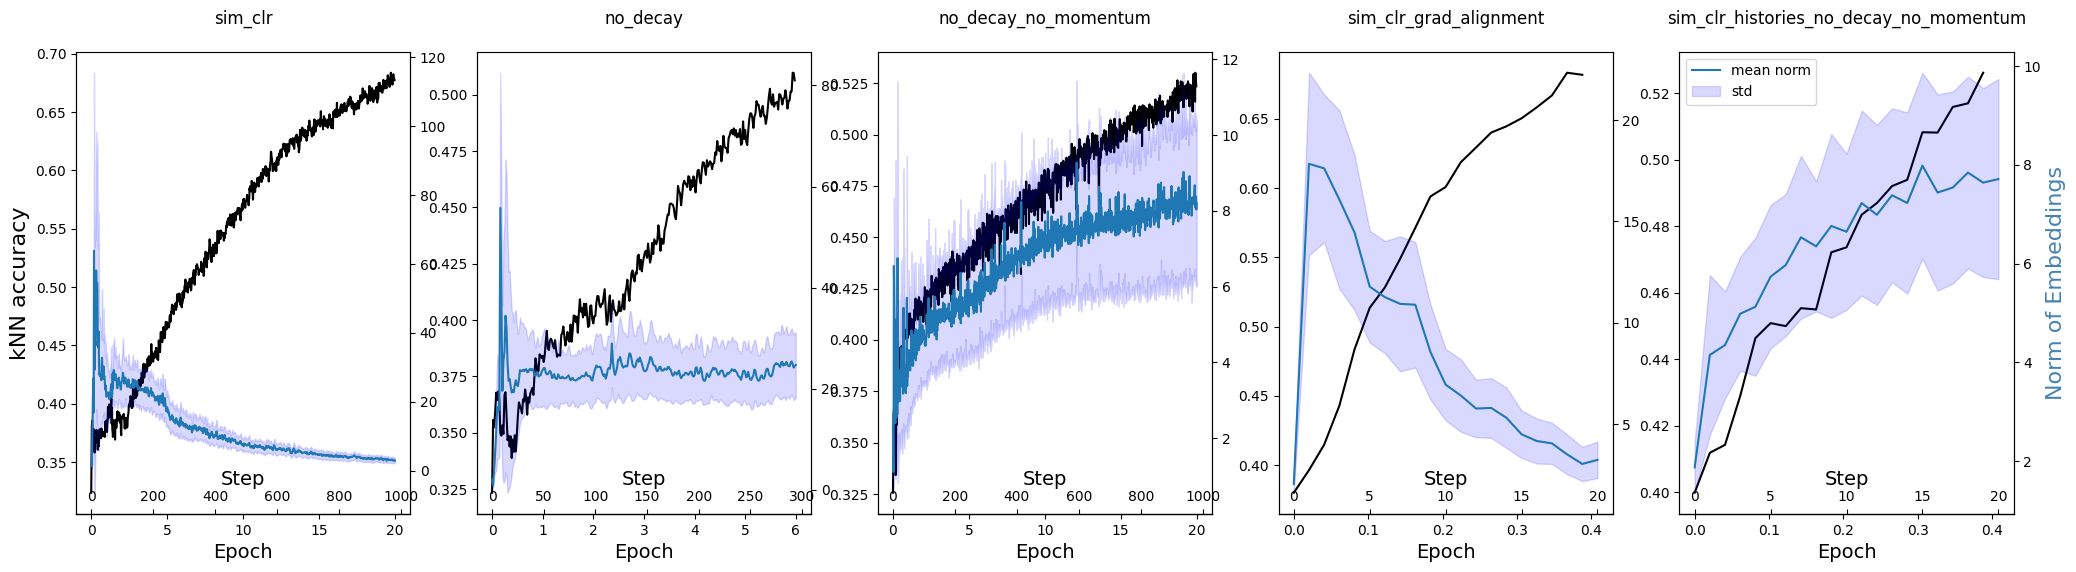

In [8]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd

def add_epoch_axis(ax):
    # secax for adding Epoch X axis at top
    def primary_to_secondary(x):
        return x / 49

    def secondary_to_primary(x):
        return x * 49
        
    # move down the original axis
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", -0.0))
    secax = ax.secondary_xaxis('bottom', functions=(primary_to_secondary, secondary_to_primary))
    secax.set_xlabel("Epoch", fontsize=14)

def _plot_norm_and_knn(df, ax, up_to_step = 1000, only_mean=True):
    embed_norms = df[df.type == "embed_norm"]
    embed_norms_tensor = torch.tensor(np.array(list(embed_norms.value)))[:up_to_step]

    ax.plot(list(df[df.type == "kNN_accuracy_cosine"].value)[:up_to_step], color="black")
    ax.set_xlabel('Step', fontsize=14)

    mean = embed_norms_tensor.mean(dim=-1)
    std = embed_norms_tensor.std(dim=-1)
    ax2 = ax.twinx()
    ax2.plot(mean, label="mean norm")
    ax2.fill_between(range(len(embed_norms_tensor)), mean+std, mean-std, color='b', alpha=.15, label="std")
    add_epoch_axis(ax)

    if not only_mean:
        ax2.plot(embed_norms_tensor.max(dim=-1).values, label="max norm")
        ax2.plot(embed_norms_tensor.min(dim=-1).values, label="min norm")

    return ax2

def plot_norm_and_knn(df, up_to_step = 1000, only_mean=True):
    fig, ax = plt.subplots()
    ax.set_ylabel('kNN accuracy', color="black", fontsize=16)
    ax2 = _plot_norm_and_knn(df, ax, up_to_step, only_mean)
    ax2.legend()
    plt.show()

def plot_dict_norm_and_knn(df_dict, up_to_step = 1000, only_mean=True, share_knn_axis=True):
    n = len(list(df_dict.keys()))
    fig = plt.figure(figsize=(n*5, 6))
    gs = fig.add_gridspec(1,n, hspace=0)
    axs = gs.subplots(sharex=share_knn_axis, sharey=share_knn_axis)
    axs[0].set_ylabel('kNN accuracy', color="black", fontsize=16)

    for ax, (variant_name, df) in zip(axs, df_dict.items()):
        ax.set_title(variant_name, pad=20)
        ax2 = _plot_norm_and_knn(df, ax, up_to_step, only_mean)
    
    ax2.set_ylabel('Norm of Embeddings', color="steelblue", fontsize=16)
    ax2.legend()
        
    fig.show()

# print(path)
# plot_norm_and_knn(df, only_mean=False)

plot_dict_norm_and_knn(df_dict, share_knn_axis=False, only_mean=True, up_to_step=1000)

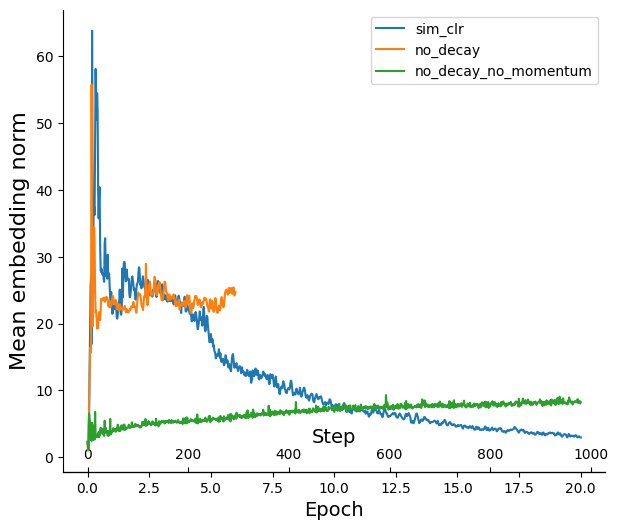

In [35]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd

def add_epoch_axis(ax):
    # secax for adding Epoch X axis at top
    def primary_to_secondary(x):
        return x / 49

    def secondary_to_primary(x):
        return x * 49
        
    # move down the original axis
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", -0.0))
    secax = ax.secondary_xaxis('bottom', functions=(primary_to_secondary, secondary_to_primary))
    secax.set_xlabel("Epoch", fontsize=14)

def _plot_norm(df, ax, up_to_step = 1000, only_mean=True, variant_name=""):
    embed_norms = df[df.type == "embed_norm"]
    embed_norms_tensor = torch.tensor(np.array(list(embed_norms.value)))[:up_to_step]

    mean = embed_norms_tensor.mean(dim=-1)
    std = embed_norms_tensor.std(dim=-1)
    ax.plot(mean, label=variant_name)
    if not only_mean:
        ax.fill_between(range(len(embed_norms_tensor)), mean+std, mean-std, alpha=.15)

def plot_norm(df, ax, up_to_step = 1000, only_mean=True):
    fig, ax = plt.subplots()
    ax.set_ylabel('kNN accuracy', color="black", fontsize=16)
    _plot_norm(df, up_to_step, only_mean)
    plt.show()

def plot_dict_norm(df_dict, up_to_step = 1000, only_mean=True, share_axis=True):
    n = len(list(df_dict.keys()))
    fig = plt.figure(figsize=(7, 6))
    gs = fig.add_gridspec(1,1, hspace=0)
    ax = gs.subplots(sharex=share_axis, sharey=share_axis)
    ax.set_ylabel('Mean embedding norm', color="black", fontsize=16)
    ax.set_xlabel("Step", fontsize=14)
    ax.spines['right'].set_visible(False)
    add_epoch_axis(ax)

    for variant_name, df in df_dict.items():
        _plot_norm(df, ax, up_to_step, only_mean, variant_name)
    ax.legend()
        
    fig.show()


paths = dict(
    sim_clr = 'batch_metrics/embed_histories.pkl',
    no_decay = 'batch_metrics/embed_histories_no_decay.pkl',
    no_decay_no_momentum = 'batch_metrics/embed_histories_no_decay_no_momentum.pkl',
    no_decay_no_momentum2 = "batch_metrics/embed_histories_no_decay_no_momentum-andrews_loss.pkl",
    no_decay_no_momentum_atr0_5 = "batch_metrics/embed_histories_attraction_factor=0.5.pkl",
)

plot_dict_norm(df_dict, share_axis=True, only_mean=True, up_to_step=1000)

In [87]:
set(df.type)

{'batch_used_indicies',
 'cos_sim_to_og_view_after_step',
 'cos_sim_to_og_view_before_step',
 'embed_norm',
 'embed_update_cos_sim',
 'kNN_accuracy_cosine',
 'og_view_grad1_cos_sim',
 'og_view_grad2_cos_sim',
 'view1_grad1_cos_sim',
 'view1and2_norm_after_optim_step',
 'view1and2_norm_before_optim_step',
 'view2_grad2_cos_sim',
 'views_cos_sim_after_step',
 'views_cos_sim_before_step'}

torch.Size([100, 2])


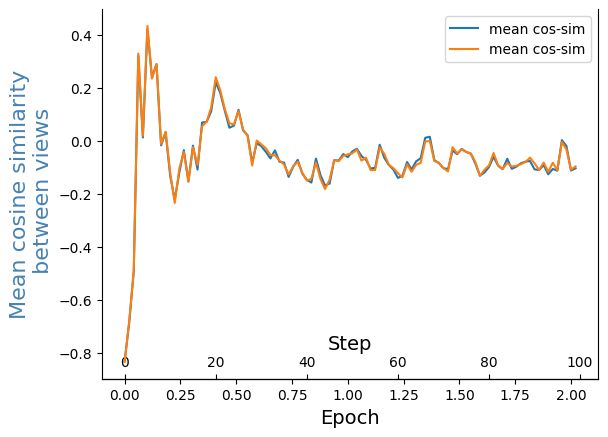

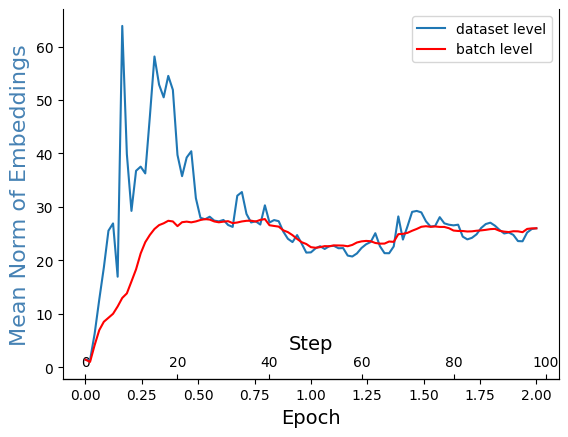

In [ ]:
from matplotlib import pyplot as plt

def plot_views_cos_sim(df, filter, up_to_step=-1, show_std=False, add_epochs=True):

    cos_sims = stack_with_len(df[df.type == filter], 1024)[:up_to_step]
    cos_sims_tensor = cos_sims
    mean = cos_sims_tensor.mean(dim=-1)#.cumsum(0)
    print(mean.shape)
    std = cos_sims_tensor.std(dim=-1)
    
    fig,ax = plt.subplots()
    ax.plot(mean, label="mean cos-sim")
    if show_std:
        ax.fill_between(range(len(mean)), mean+std, mean-std, color='b', alpha=.15, label="std")
    ax.set_xlabel('Step', fontsize=14)
    ax.set_ylabel('Mean cosine similarity\n between views', color="steelblue", fontsize=16)
    ax.legend()
    if add_epochs:
        add_epoch_axis(ax)
    plt.show()

up_to = 100
df = df_dict["sim_clr_grad_alignment"]
plot_views_cos_sim(df, "embed_update_cos_sim", up_to_step=up_to, show_std=False, add_epochs=True)
df = df_dict["sim_clr_histories_no_decay_no_momentum"]
# plot_views_cos_sim(df, "update1_grad1_cos_sim", up_to_step=up_to, show_std=True, add_epochs=True)

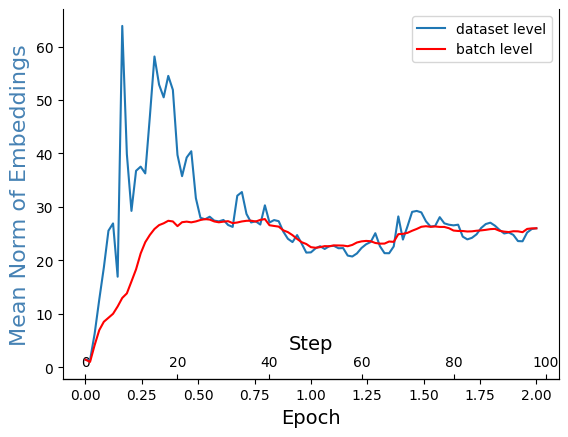

In [24]:
from matplotlib import pyplot as plt
import numpy as np

def plot_embed_norm_and_batch_embed_norm(df, up_to_step=-1, show_std=False):

    embed_norms = df[df.type == "embed_norm"]
    embed_norms_tensor = torch.tensor(np.array(list(embed_norms.value)))[1:up_to_step]
    mean = embed_norms_tensor.mean(dim=-1)
    std = embed_norms_tensor.std(dim=-1)
    
    diffs = stack_with_len(df[df.type == "view1and2_norm_after_optim_step"], 1024) - stack_with_len(df[df.type == "view1and2_norm_before_optim_step"], 1024)
    mean_diffs_cumsum = diffs[:up_to_step].mean(dim=(1,2)).cumsum(dim=0)[:-1]
    mean_diffs_cumsum += mean[0] - mean_diffs_cumsum[0] # adjust so step one both mean lines are the same
    mean_diffs_std = diffs[:up_to_step].std(dim=(1,2))[:-1]

    fig,ax = plt.subplots()
    ax.plot(mean, label="dataset level")
    ax.plot(mean_diffs_cumsum, color="red", label="batch level")
    if show_std:
        ax.fill_between(range(len(embed_norms_tensor)), mean+std, mean-std, color='b', alpha=.15, label="std")
    ax.set_xlabel('Step', fontsize=14)
    ax.set_ylabel('Mean Norm of Embeddings', color="steelblue", fontsize=16)
    ax.legend()
    add_epoch_axis(ax)
    plt.show()


df = df_dict["sim_clr"]
plot_embed_norm_and_batch_embed_norm(df, up_to_step=100, show_std=False)

In [131]:
diff_lst = []
for before, after in zip(df[df.type == "views_cos_sim_after_step"].itertuples(), df[df.type == "views_cos_sim_before_step"].itertuples()):
    diff = after.value - before.value
    if len(diff) == 1024:
        diff_lst.append(diff)

diffs = torch.stack(diff_lst)
mean_diffs_cumsum = diffs.mean(dim=-1)

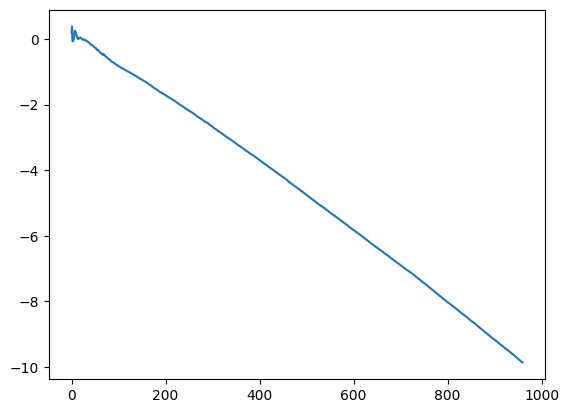

In [142]:
import torch
from matplotlib import pyplot as plt
cur_diffs = mean_diffs_cumsum[:1000]
y = cur_diffs.detach().flatten().cumsum(dim=-1)
x = torch.arange(len(cur_diffs))
plt.plot(x,y)
plt.show()